In [1]:
import os
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import secrets
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# Define paths for dataset and model
base_path = "C:/Users/kimaa/OneDrive/Desktop"
data_path = os.path.join(base_path, "imgs", "train")
model_dir = os.path.join(base_path, "model", "vgg16_fine_tuned")


print("Data Directory:", data_path)
print("Model Directory:", model_dir)



Data Directory: C:/Users/kimaa/OneDrive/Desktop\imgs\train
Model Directory: C:/Users/kimaa/OneDrive/Desktop\model\vgg16_fine_tuned


In [4]:
# Preprocessing functions for the images
def enhance_brightness(img, value_increment):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_img)
    v = cv2.add(v, value_increment)
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

def change_contrast(img, level):
   img = Image.fromarray(img.astype('uint8'))
   factor = (259 * (level + 255)) / (255 * (259 - level))
   def contrast(c):
        return 128 + factor * (c - 128)
   return np.array(img.point(contrast))

def preprocess_img(img):
   img = np.array(img)
   x = secrets.randbelow(2)
   if x == 0:
        # img = pad_img(img)
        img = enhance_brightness(img, secrets.randbelow(26))
        img = change_contrast(img, secrets.randbelow(51))
   else:
        # img = pad_img(img)
        img = change_contrast(img, secrets.randbelow(51))
        img = enhance_brightness(img, secrets.randbelow(26))
   return img


In [5]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=0.01,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode="nearest",
    validation_split=0.2,
    preprocessing_function=preprocess_img
)



In [6]:
train_data = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=128,
    subset='training',
    shuffle=True
)


Found 17943 images belonging to 10 classes.


In [7]:
test_data = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=128,
    subset='validation',
    shuffle=True
)

Found 4481 images belonging to 10 classes.


In [8]:
def setup_fine_tuning(base_model, fine_tune_at=-4, batch_wise=True):
    """
    Sets up the model for fine-tuning.
    base_model: The pre-loaded base model (e.g., VGG16).
    fine_tune_at: The index of the layer from which fine-tuning should start.
    batch_wise: Whether to apply fine-tuning batch-wise.
    """
    if batch_wise:
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(10, activation='softmax')  # Assuming 10 classes
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(learning_rate=1e-4, momentum=0.9),
                  metrics=['accuracy'])
    return model

# Load the VGG16 model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


In [9]:
# Choose fine-tuning type
model_batch_wise = setup_fine_tuning(base_model, fine_tune_at=-4, batch_wise=True)  # Adjust as needed


In [10]:
# Choose fine-tuning type
model_no_batch_wise = setup_fine_tuning(base_model, fine_tune_at=-4, batch_wise=True)  # Adjust as needed


In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
K.set_floatx('float32')

In [12]:
# Setup model checkpointing
checkpoint_path = os.path.join(model_dir, "model_vgg_batched-{epoch:02d}-{val_accuracy:.2f}.keras")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Start training
history = model_batch_wise.fit(train_data,
                    epochs=20,  # Adjust the number of epochs according to your need
                    validation_data=test_data,
                    callbacks=[checkpoint_callback, early_stopping_callback])

# Save the model
try:
    model_batch_wise.save(os.path.join(model_dir, 'final_model_vgg_batchwise.keras'))
except Exception as e:
    print(f"An error occurred while saving the model: {e}")



Epoch 1/20


C:\Users\kimaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1367 - loss: 3.5192
Epoch 1: val_accuracy improved from -inf to 0.31756, saving model to C:/Users/kimaa/OneDrive/Desktop\model\vgg16_fine_tuned\model_vgg_batched-01-0.32.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 966s 7s/step - accuracy: 0.1369 - loss: 3.5120 - val_accuracy: 0.3176 - val_loss: 1.9257
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4325 - loss: 1.6097
Epoch 2: val_accuracy improved from 0.31756 to 0.76501, saving model to C:/Users/kimaa/OneDrive/Desktop\model\vgg16_fine_tuned\model_vgg_batched-02-0.77.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 965s 7s/step - accuracy: 0.4333 - loss: 1.6075 - val_accuracy: 0.7650 - val_loss: 0.7341
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8098 - loss: 0.6334
Epoch 3: val_accuracy improved from 0.76501 to 0.88217, saving model to C:/Users/kimaa/OneDrive/Desktop\model\vgg16_fine_tuned\model_vgg_batched-03-0.88.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 964s 7s/step - ac

In [13]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

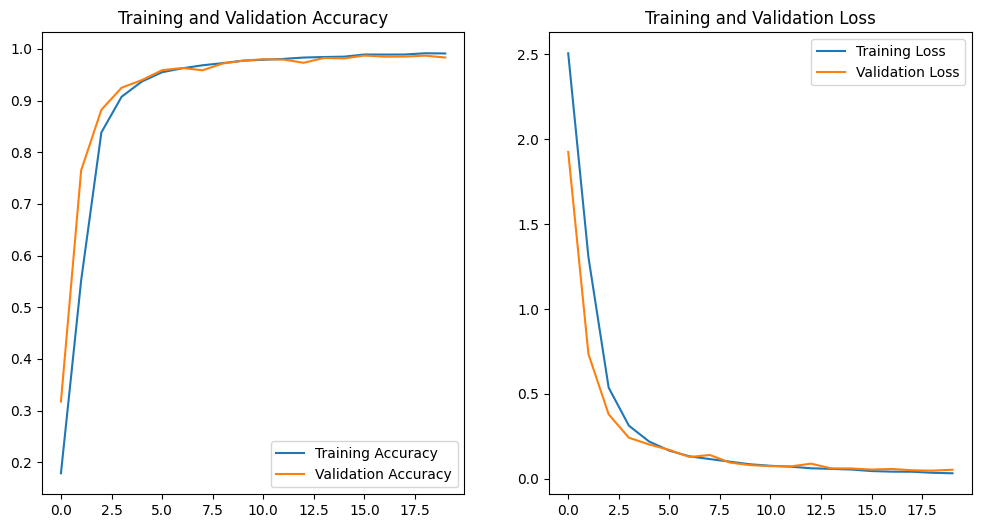

In [14]:
plot_training_history(history)

In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_batch_wise.evaluate(test_data)
print(f"Test accuracy: {test_accuracy*100:.2f}%, Test loss: {test_loss:.2f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.9843 - loss: 0.0479
Test accuracy: 98.44%, Test loss: 0.05


In [21]:
# Setup model checkpointing
checkpoint_path = os.path.join(model_dir, "model_vgg_not_batched-{epoch:02d}-{val_accuracy:.2f}.keras")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Start training
history = model_no_batch_wise.fit(train_data,
                    epochs=20,  # Adjust the number of epochs according to your need
                    validation_data=test_data,
                    callbacks=[checkpoint_callback, early_stopping_callback])

# Save the model
try:
    model_no_batch_wise.save(os.path.join(model_dir, 'final_model_vggnot_batchwise.keras'))
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3683 - loss: 2.5546
Epoch 1: val_accuracy improved from -inf to 0.85829, saving model to C:/Users/kimaa/OneDrive/Desktop\model\vgg16_fine_tuned\model_vgg_not_batched-01-0.86.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 980s 7s/step - accuracy: 0.3698 - loss: 2.5465 - val_accuracy: 0.8583 - val_loss: 0.4650
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8956 - loss: 0.3630
Epoch 2: val_accuracy improved from 0.85829 to 0.93774, saving model to C:/Users/kimaa/OneDrive/Desktop\model\vgg16_fine_tuned\model_vgg_not_batched-02-0.94.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 970s 7s/step - accuracy: 0.8957 - loss: 0.3627 - val_accuracy: 0.9377 - val_loss: 0.2272
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9404 - loss: 0.2026
Epoch 3: val_accuracy improved from 0.93774 to 0.94800, saving model to C:/Users/kimaa/OneDrive/Desktop\model\vgg16_fine_tuned\model_vgg_not_batched-03-0.95.keras
141/141 ━━━━━━━━━━━━━━━

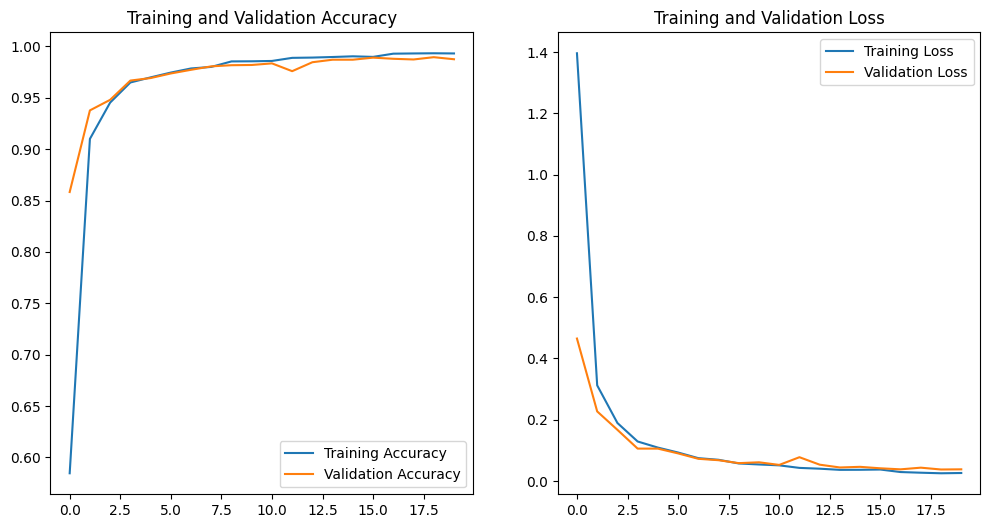

In [22]:
plot_training_history(history)

In [23]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_no_batch_wise.evaluate(test_data)
print(f"Test accuracy: {test_accuracy*100:.2f}%, Test loss: {test_loss:.2f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 166s 5s/step - accuracy: 0.9907 - loss: 0.0353
Test accuracy: 99.09%, Test loss: 0.03
